# Case study: Differential gene expression 	between cells with and without activation of the tumor suppressor p53

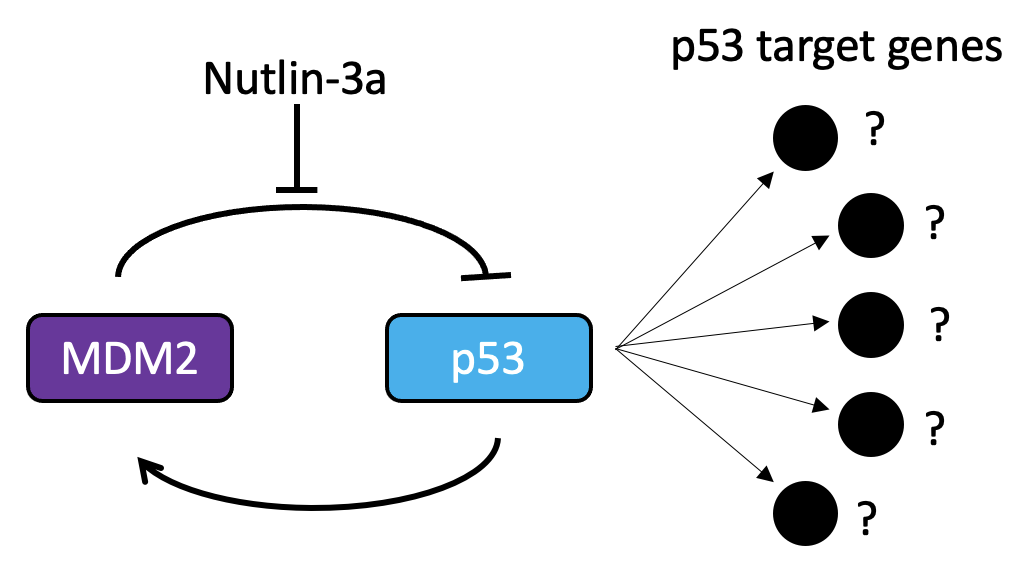

MCF-7 (breast cancer cell line) cells with and without Nutlin-3a stimilation.

**Research question:** Which genes are downstream of p53 (i.e. are upregulated by p53)?

## Step 0: set up working directory

In [ ]:
mkdir -p /mnt/storage/$USER/jupyternotebooks/bulk_RNA_seq
cd /mnt/storage/$USER/jupyternotebooks/bulk_RNA_seq

## Step 1: get reads
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE47042

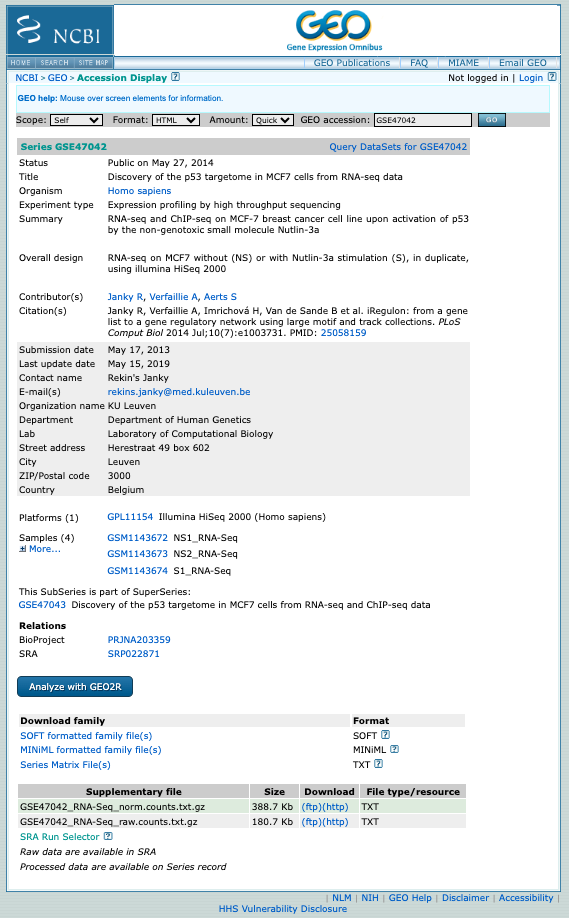

Click on "SRA Run Selector"
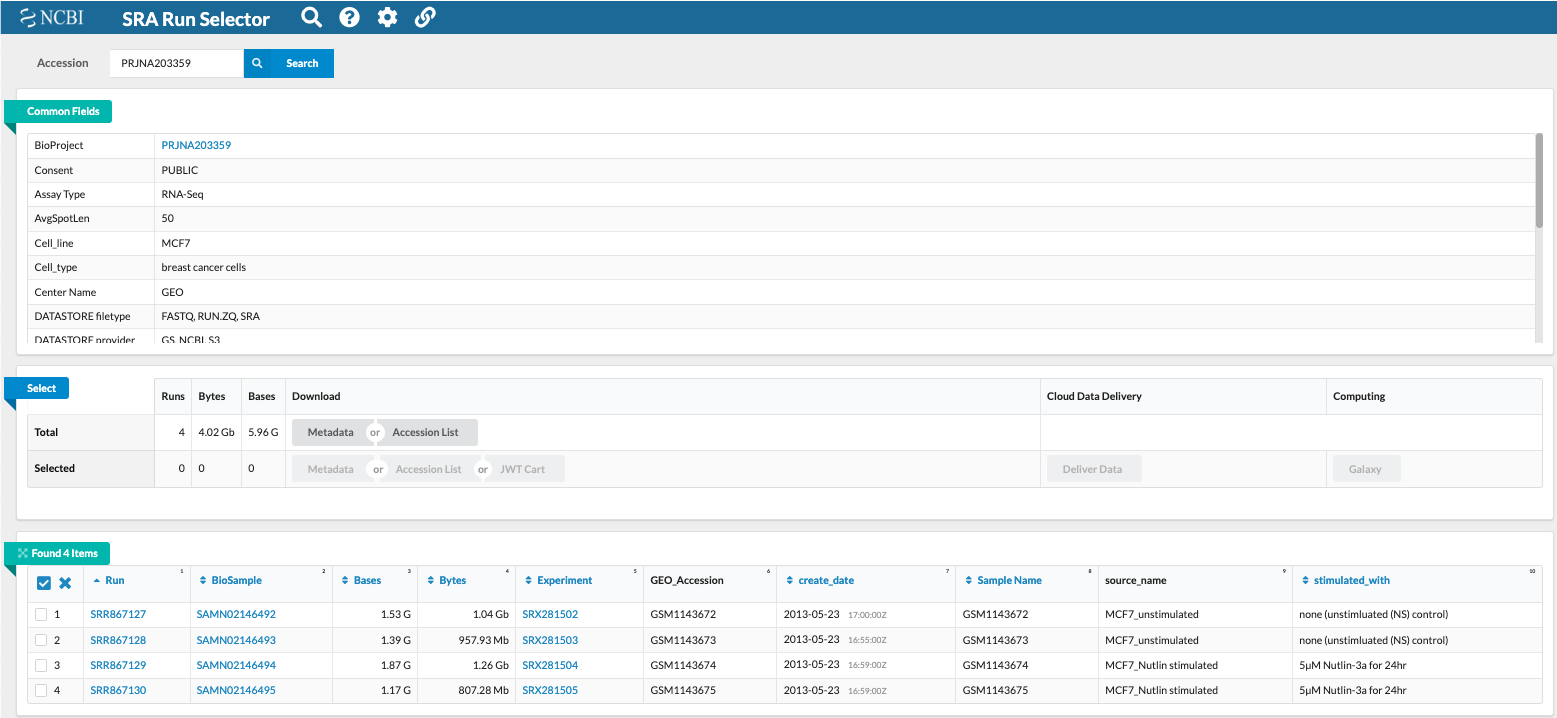

Download fastq files using fastq-dump. **Before running fastq-dump for the first time run the command below.** This will prevent unnecessary files to be saved in your home folder, which has a strict quotum.

In [ ]:
vdb-config -s /repository/user/cache-disabled=true

In [ ]:
mkdir fastq_files_test #make directory to store fastq files

In [ ]:
# SRR867127 SRR867128: Download the fastq files for two unstimulated samples (SRR867127, SRR867128)
# SRR867129 SRR867130: Download the fastq files for two nutlin stimulated sampels (SRR867129, SRR867130)
# --split-files: Split read 1 and read 2 data (necessary for paired-end data)
# --outdir fastq_files_test: Save files in the specified folder
# --verbose: Show all log messages
# -X 5: Only download the first 5 reads, don't use this for real data. We put it here for testing purposes
fastq-dump \
    SRR867127 SRR867128 \
    SRR867129 SRR867130 \
    --split-files \
    --outdir fastq_files_test \
    --verbose \
    -X 5

**Some notes on fastq-dump**
- Before running fastq-dump run:
    - vdb-config -s /repository/user/cache-disabled=true
    - This will prevent unnecessary files to be saved in your home folder, which has a strict quotum.
- If you are not sure downloading (using sra-tools / fastq-dump) works, please, first try to run with: -X 5 as an argument to fastq-dump. This will download only the first 5 reads, and is a good test that everything works
- Sometimes you get a warning or error sounding like "timeout exhausted while reading file within network system module". If the download does not stop - you can ignore this warning.
- After downloading - you should calculate the number of reads downloaded (`wc -l` divided by four). This should correspond to the number of spots for that SRR entry.
- If the fastq-dump crashes, or the number of reads does not match, or, the fastq file seems broken. Retry the download.
- Do not download too many files in parallel - this may increase the chance of errors!

In [ ]:
ls fastq_files_test

In [ ]:
head -n4 fastq_files_test/SRR867127_1.fastq

For each read there are 4 lines in a fastq file. Above information on the first read of SRR867127_1.fastq is shown.

Field 1: sequence identifier
>@SRR867127.1 HWI-ST571:122:D0HFTACXX:4:1101:1454:2139 length=50

Field2: raw sequence 
>CAGCTTTCTAGGGCTGGAAGTCTCAAATAGAACTCACCTGTTCCCCAACC

Field3: description
>+SRR867127.1 HWI-ST571:122:D0HFTACXX:4:1101:1454:2139 length=50

Field4: Quality of each nucleotide encode as ACII (ranges from 0x21 to 0x7e)
>@@@?DFFDF?HFHIIIGG>FCAFGHG@EHGHIDE?FHHDHF@BFF@@?DG

Here are the quality value characters in left-to-right increasing order of quality (ASCII) (source wikipedia):
>!"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~

Let's download all reads, please **do not** run this during class. It will take a long time to finish. You will have access to the pre-downloaded files.

In [ ]:
mkdir fastq_files #make directory to store fastq files
fastq-dump \
    SRR867127 SRR867128 \
    SRR867129 SRR867130 \
    --split-files \
    --outdir fastq_files \
    --verbose 

In [ ]:
ls fastq_files

We will rename the files so it is easier to distinguish what data we are looking at.

- MCF7_NS1: MCF7 without stimulation, replicate 1
- MCF7_NS2: MCF7 without stimulation, replicate 2
- MCF7_S1: MCF7 with nutlin stimulation, replicate 1
- MCF7_S2: MCF7 with nutlin stimulation, replicate 2

In [ ]:
mv fastq_files/SRR867127_1.fastq fastq_files/MCF7_NS1.fastq
mv fastq_files/SRR867128_1.fastq fastq_files/MCF7_NS2.fastq
mv fastq_files/SRR867129_1.fastq fastq_files/MCF7_S1.fastq
mv fastq_files/SRR867130_1.fastq fastq_files/MCF7_S2.fastq

In [ ]:
cat fastq_files/MCF7_NS1.fastq | wc -l

In [ ]:
echo 122549916/4 | bc #the number of reads is the number of lines in the fastq file divided by four

We have downloaded 30,637,479 reads for MCF7_NS1.fastq, this is consistent with the number on SRA:

https://trace.ncbi.nlm.nih.gov/Traces/index.html?view=run_browser&page_size=10&acc=SRR867127&display=reads

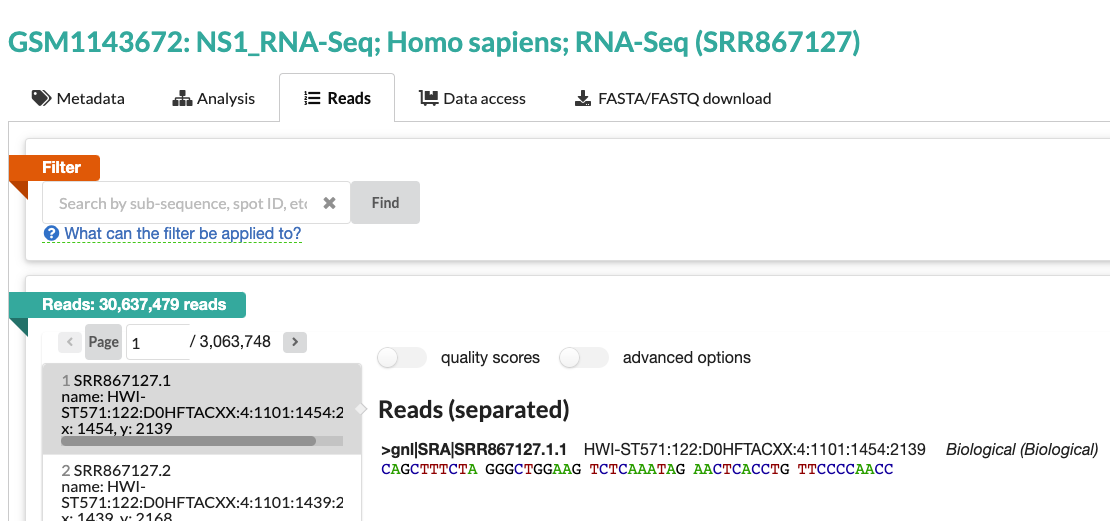

## Step 2 Quality control using FASTQC

After receiving sequencing data your first step should be to check your data quality. This step helps to identify potential technical biases that might affect your analysis. Based on this evaluation you might need to pre-process your data to improve the quality. 

[FastQC](http://www.bioinformatics.babraham.ac.uk/projects/fastqc/) is a tool that produces a quality analysis report on FASTQ files.

    fastqc fastqfile -o outputdir  

Useful links:

* [FastQC report for a good Illumina dataset](http://www.bioinformatics.babraham.ac.uk/projects/fastqc/ "Title")
* [FastQC report for a bad Illumina dataset](http://www.bioinformatics.babraham.ac.uk/projects/fastqc/bad_sequence_fastqc.html)
* [Adapter contaminated run](http://www.bioinformatics.babraham.ac.uk/projects/fastqc/RNA-Seq_fastqc.html)
* [Online documentation for each FastQC report](http://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/)
* [Video tutorial](http://www.youtube.com/watch?v=bz93ReOv87Y)

Look through the individual reports and evaluate them according to your experiment type.

The FastQC reports I find most useful are:

* The Per base sequence quality report, which can help you decide if sequence trimming is needed before alignment.
* The Sequences Duplication Levels report, which helps you evaluate library enrichment / complexity. But note that different experiment types are expected to have vastly different duplication profiles.
* The Overrepresented Sequences report, which helps evaluate adapter contamination.

We will run FastQC on a small test fastq file. Let's make a link to this file in our working directory

In [ ]:
ln -sf /mnt/nfs/data/RNA-seq/MCF7/test.fastq fastq_files_test

Generate a directory to store the FastQC report and run FastQC.

In [ ]:
mkdir fastqc_test

In [ ]:
/usr/bin/fastqc -o fastqc_test fastq_files_test/test.fastq

In [ ]:
ls fastqc_test

FastQC will generate an html report on your fastq file. Open this html file to have a look at the report.

In this case sequencing quality looks good

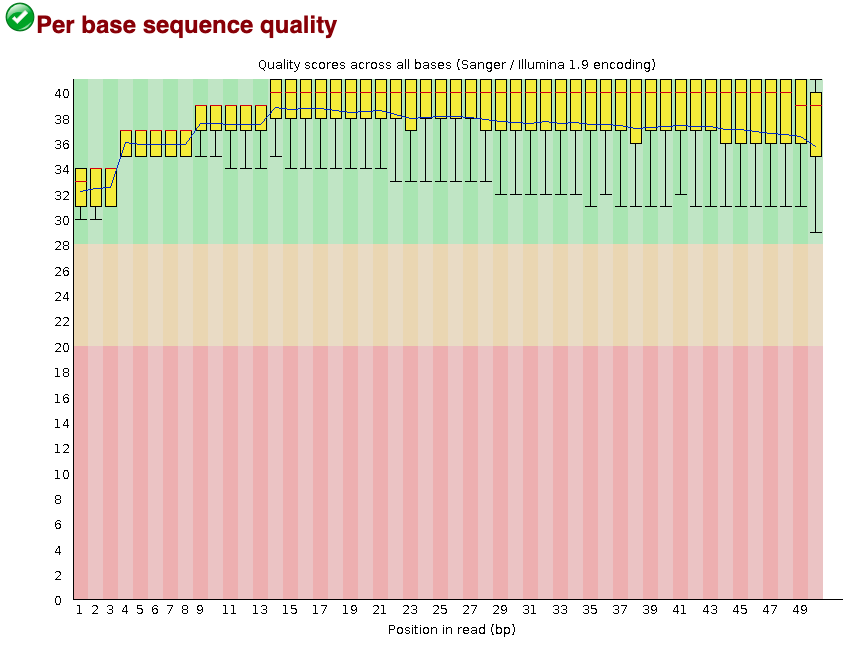

However, there seems to be some adaptor contamination.
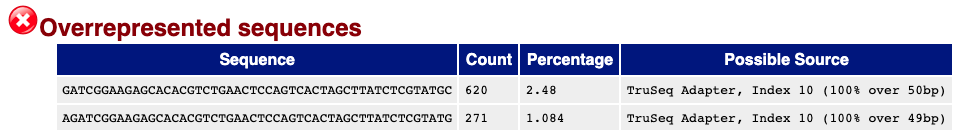

These adaptors can be trimmed away using tools like [cutadapt](https://cutadapt.readthedocs.io/en/stable/)

# Step 3: alligning reads to a reference genome

Next we will allign the reads to the genome. For this we need an allignment tool. Many of such tools exists, in this excercise we will use STAR.

In order to be able to run STAR it first needs to create a database of the reference genome of interest. In this case we want to map the reads to hg38 (the human reference genome) so we need a database for hg38. Creating such a database takes a long time. For this reason a pre-generate one can be found at this location:
    
    /mnt/storage/sdewin/STAR/star_db_hg38

STAR has very extensive documentation that can be found in [its manual](https://github.com/alexdobin/STAR/blob/master/doc/STARmanual.pdf).

Let's create an output directory for the allignment files and run STAR.

In [ ]:
mkdir alignment_test
STAR \
    --genomeDir /mnt/storage/sdewin/STAR/star_db_hg38 \
    --runThreadN 2 \
    --readFilesIn fastq_files_test/test.fastq \
    --outFileNamePrefix alignment_test/test.

In [ ]:
ls alignment_test

STAR will generate several files:
- A file containing the actual alignemnt (test.Aligned.out.sam)
- A log file containing information on the aligment (test.Log.final.out)
- Several other log files.

In [ ]:
cat alignment_test/test.Log.final.out

In [ ]:
cat alignment_test/test.Aligned.out.sam | head

The SAM file starts with a heading section, the headings always begin with the "@" symbol.

In [ ]:
cat alignment_test/test.Aligned.out.sam | grep -v "^@" | head -n 1

The actual alignment section (not starting with the "@" symbol) has 11 mandatory fields (columns) and each read is represented as a single row.

The fields are:
1. QNAME: Query template name (SRR867127.1)
2. FLAG: bitwise FLAG (16)
3. RNAME: References sequence NAME (chr11)
4. POS: 1- based leftmost mapping POSition (73662410)
5. MAPQ: mapping quality (255)
6. CIGAR: CIGAR string (50M)
7. RNEXT: Ref. name of the mate/next read (\*)
8. PNEXt: Position of the mate/next read (0)
9. TLEN: observed Template LENgth (0)
10. SEQ: segment sequence (GGTTGGGGAACAGGTGAGTTCTATTTGAGACTTCCAGCCCTAGAAAGCTG)
11. QUAL: ASCII of Phred-scaled base QUALity+33 (GD?@@FFB@FHDHHF?EDIHGHE@GHGFACF>GGIIIHFH?FDFFD?@@@)

There can be further optional fields (SAMtags).

These are represented like this

    <TAG>:<type>
    
With the type being one of the following: A (character), B (general array), f (real number), H (hexadecimal array), i (integer), or Z (string).

- NH:i Number of reported alignments that contain the query in the current record (1)
- HI:i Query hit index (1)
- AS:i Alignment score generated by aligner (49)
- nM:i Edit distance to the reference (0)
- ...

For more information on these fields see: https://en.wikipedia.org/wiki/SAM_(file_format)
To decode bitwise flags see: https://www.samformat.info/sam-format-flag

Interpretation of the read displayed above:

    Read SRR867127.1 (QNAME) is mapped to the reverse strand (bitwise FLAG 16) and is located on chromosome 11 (RNAME) at position 73662410 (POS) and itt has 50 matches to the reference genome (CIGAR 50M).

SAM files are plain text files. For this reason they take a lot of space. For this reason we usually don't store plain SAM files on disk but convert them to bam files (which is a binary file). To do this the file has to be sorted first (based on genomic position), both the sorting and converting to bam can be accomplished using samtools.

In [ ]:
#-O output a BAM file
#-o name of the bam file
samtools sort alignment_test/test.Aligned.out.sam \
    -O BAM \
    -o alignment_test/test.Aligned.out.bam

In [ ]:
ls -lh alignment_test/ 

As you can see, the bam file is a lot smaller (1.6M vs 5.2M). 
In order to quickly inspect bam files (for example in IGV, see below) we need to index the file. Again we use samtools for this.

In [ ]:
samtools index alignment_test/test.Aligned.out.bam

In fact we can actually instruct STAR to directly output a bam file instead of generating a sam file.

In [ ]:
STAR \
    --genomeDir /mnt/storage/sdewin/STAR/star_db_hg38 \
    --runThreadN 2 \
    --readFilesIn fastq_files_test/test.fastq \
    --outFileNamePrefix alignment_test/test.bam_directly \
    --outSAMtype BAM SortedByCoordinate 

In [ ]:
ls -lh alignment_test/ 

Using samtools we can also inspect bam files.

For example we can view the bam file:

In [ ]:
samtools view alignment_test/test.Aligned.out.bam | head -n 1

We can see how many reads mapped to each chromosome:

In [ ]:
samtools idxstats alignment_test/test.Aligned.out.bam 
# this commands outputs a tab delimited file with the following columns:
# Col 1 chromosome name
# Col 2 length of the chromosoem
# Col 3 number of reads mapped to this chromosome
# Col 4 number of unmapped read fragments

We can get info on the different SAM flags present in the file:

In [ ]:
samtools flagstat alignment_test/test.Aligned.out.bam

Let's allign all reads to the reference genome, again please **do not** run this in class

In [ ]:
mkdir alignment

In [ ]:
FILES_TO_ALIGN=`ls fastq_files | grep fastq`
echo "Following files will be aligned:" 
echo ${FILES_TO_ALIGN} | sed "s/ /, /g"              #Print fastq files and put commas between each file name
for fastq_file in ${FILES_TO_ALIGN}                  #Loop over all fastq files
do
    SAMPLE_NAME=`echo ${fastq_file} | cut -f 1 -d .` #Get the sample name by remove '.fastq'
    echo "Aligning ${SAMPLE_NAME}" 
    STAR \
        --genomeDir /mnt/storage/sdewin/STAR/star_db_hg38 \
        --runThreadN 20 \
        --readFilesIn fastq_files/${fastq_file} \
        --outFileNamePrefix alignment/${SAMPLE_NAME}. \
        --outSAMtype BAM SortedByCoordinate 
done

In [ ]:
ls alignment | grep bam

## Step 4: count number of reads overlapping each gene.

Before we can start with differential expression analysis we need to count, for each sample seperatly, how many reads overlap each gene. This will generate a count matrix which we can use for identifying genes for which the expression is different between our two conditions.

For this we will use the program:

    featureCounts
    
and we will need a gtf file.

A GTF file is a file containing genomic features (like genes, exons, introns, ...) along with their genomic locations and other metadata. This is a tab-seperated file containing the following fields:

1. seqname: name of the chromosome (or scaffold)
2. source: name of the program that generated this feature or the data source
3. start: genomic start position of the feature
4. end: genomic end position of the feature
5. score: a floating point value of the score of the feature (optional)
6. strand: wether the feature is on the forward (+) or reverse (-) strand.
7. frame: One of '0', '1' or '2'. '0' indicates that the first base of the feature is the first base of a codon, '1' that the second base is the first base of a codon, and so on..
8. attribute: a semicolon (;) separated list of tag value pairs containing additional information

see https://www.ensembl.org/info/website/upload/gff.html for more information.

A gtf file for hg38 can be found at this location:

    /mnt/storage/sdewin/STAR/star_db_hg38/gencode.v26.primary_assembly.annotation.gtf

Let's make a symbolic link to this file

In [ ]:
ln -sf /mnt/storage/sdewin/STAR/star_db_hg38/gencode.v26.primary_assembly.annotation.gtf .

In [ ]:
head gencode.v26.primary_assembly.annotation.gtf

As you can see, the file starts with some metadata (starting with a '#' symbol), this is followed by the actual features. 

For example:
    
    chr1	HAVANA	gene	11869	14409	.	+	.	gene_id "ENSG00000223972.5"; gene_type "transcribed_unprocessed_pseudogene"; gene_name "DDX11L1"; level 2; havana_gene "OTTHUMG00000000961.2";
 

This is a gene located at chr1:11869-14409 on the positive strand. The gene is annotated by the HAVANA group (https://www.ensembl.org/info/genome/genebuild/manual_havana.html) it has the gene_id ENSG00000223972.5 and gene name DDX11L1. The gene is a transcribed_unprocessed_pseudogene.

Let's count the reads overlapping these features.

In [ ]:
mkdir counts

In [ ]:
#-Q 10 only count reads with a minimum mapping quality of 10
#-g gene_name use gene_name as feature names (you can also use gene_id, although this is less human readable)
#-a gencode.v26.primary_assembly.annotation.gtf specify the annotaiton file
#-o counts/mcf7_ns_s.count specify the output file
#alignment/*.bam count for all the bam files in the alignment folder
featureCounts \
    -Q 10 \
    -g gene_name \
    -a gencode.v26.primary_assembly.annotation.gtf \
    -o counts/mcf7_ns_s.counts \
    alignment/*.bam

As you can see, the program outputs some information on the amount of reads that overlap the features in the gtf file. It takes around 1 minute to count each bam file. 

In [ ]:
ls counts

In [ ]:
head counts/mcf7_ns_s.counts

This is the main output of the featureCounts program. It contains a lot of information (including the genomic location of each feature) and some metadata starting with the "#" symbol. Let's focus on the most interesting columns and format the output a bit. 

In [ ]:
head counts/mcf7_ns_s.counts \
    | grep -v "#" \
    | cut -f 1,7,8,9,10 \
    | sed "s/alignment\///g" \
    | sed "s/.Aligned.sortedByCoord.out.bam//g" \
    | column -t

This is a count matrix containing the number of reads overlapping genes (rows) for each sample (column). We will use this count matrix to perform differential expression.

Let's save this formatted count matrix to disk

In [ ]:
cat counts/mcf7_ns_s.counts \
    | grep -v "#" \
    | cut -f 1,7,8,9,10 \
    | sed "s/alignment\///g" \
    | sed "s/.Aligned.sortedByCoord.out.bam//g" \
    > counts/mcf7_ns_s.counts.formatted

In [ ]:
head counts/mcf7_ns_s.counts.formatted | column -t

How many counts does the gene MDM2 have for the different samples?

In [ ]:
cat counts/mcf7_ns_s.counts.formatted | grep MDM2

As you can see, the expression of this gene is much higher in the stimulated cells compared to the non-stimulated cells.

In the next excercise we will show how you can find more of such genes and how you can test wether this difference is significant or not.